In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
np.random.seed(seed=0)

In [3]:
# Reviews.csv 파일을 data라는 이름의 데이터프레임에 저장. 단, 10만개의 행(rows)으로 제한.
data = pd.read_csv("Reviews.csv", nrows = 100000)
print('전체 리뷰 개수 :',(len(data)))

전체 리뷰 개수 : 100000


In [4]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
data = data[['Text','Summary']]
data.head()

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy


In [6]:
# 랜덤으로 10개의 샘플 출력
data.sample(10)

,Text,Summary
3582,"I rarely eat anything but whole wheat pasta, b...",reminds me of Italy
60498,I absolutely love 5-hour ENERGY! I use it afte...,5-hour ENERGY Highly Recommend!
53227,"this chocolate is a true treat to eat, perfect...",supreme chocolate
21333,Greenies are very muched loved as a tatsy Trea...,Excellent Teeth Cleaner
3885,I love these noodles. They are really great f...,Great and good price!
51521,These are great! As a lover of all chips I'm s...,"Delicious, just like Salt and Vinegar Chips!"
84261,Like other customers I divide these into handf...,"Great snack, great value"
10685,I recommend this instead for the same price: <...,"It's ok, but certainly not worth the cost"
59948,"The noodles were all very broken, but the tast...",Knorr's beef noodles
41032,"Despite claiming they use the ""finest ingredie...",HORRIBLE INGREDIENTS


In [7]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


In [8]:
# text 열에서 중복인 내용이 있다면 중복 제거
data.drop_duplicates(subset=['Text'], inplace=True)
print("전체 샘플수 :", len(data))

전체 샘플수 : 88426


In [9]:
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


In [10]:
# Null 값을 가진 샘플 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 88425


In [12]:
# 전처리 함수 내 사용
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [13]:
# NLTK의 불용어
stop_words = set(stopwords.words('english'))
print('불용어 개수 :', len(stop_words))
print(stop_words)

불용어 개수 : 179
{'those', 'at', 'was', 'an', 'under', 'itself', 'themselves', 'over', 'himself', 'theirs', 'while', 'above', "wasn't", "didn't", 'this', 'because', 's', 'isn', 'their', "couldn't", 'ours', "should've", "haven't", 'can', 'that', 'them', 'mightn', 'some', 'o', "hadn't", "you'd", 'we', 'and', 'whom', 'for', 'you', 'there', 'such', 'with', "aren't", 'were', 've', "it's", 'yourself', 'all', 'what', 'into', "hasn't", "won't", 'just', 'd', 'than', "that'll", 'it', 'a', 'how', 'ma', 'once', 'shan', 'most', 'no', 'his', 'been', 'had', 'yourselves', 'ain', 'of', 'is', 'shouldn', 'as', "wouldn't", 'my', 'from', 'why', 'don', 'then', 'between', 'myself', 'up', 'needn', 'couldn', 'him', 'do', 'both', 'herself', 'won', 'in', 'now', "you've", 'll', "mustn't", 'off', 'where', 'which', 'have', 'its', 'here', 'during', 'hasn', 'nor', 'hers', 'further', 'other', 'after', 'the', 'through', 'doesn', 'only', "weren't", 'until', 'hadn', 'own', 'be', 'each', 'aren', 'does', 'to', 'down', 'our', '

In [14]:
# 전처리 함수
def preprocess_sentence(sentence, remove_stopwords = True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열  제거 Ex) my husband (and myself) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [15]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'
print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, 0))

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [16]:
# Text 열 전처리
clean_text = []
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))
clean_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [17]:
# Summary 열 전처리
clean_summary = []
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, 0))
clean_summary[:5]

C:\Users\jikim\anaconda3\lib\site-packages\bs4\__init__.py:329: MarkupResemblesLocatorWarning: "..." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Users\jikim\anaconda3\lib\site-packages\bs4\__init__.py:414: MarkupResemblesLocatorWarning: "http://www.amazon.com/gp/product/b007i7yygy/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy']

In [18]:
data['Text'] = clean_text
data['Summary'] = clean_summary

In [19]:
# 길이가 공백인 샘플은 NULL 값으로 변환
data.replace('', np.nan, inplace=True)
print(data.isnull().sum())

Text        0
Summary    70
dtype: int64


In [20]:
data.dropna(axis = 0, inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 88355


텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


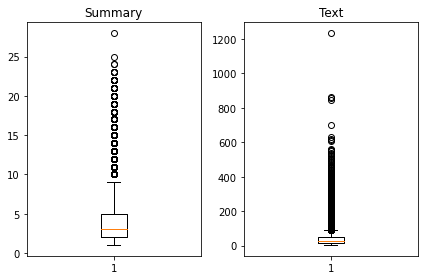

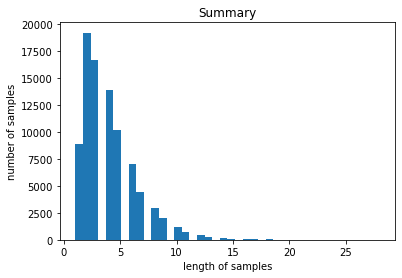

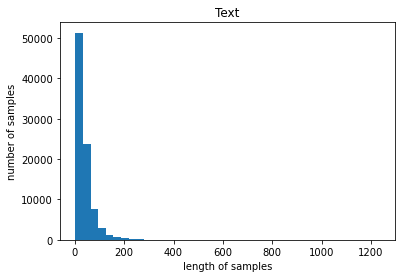

In [21]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [22]:
text_max_len = 50
summary_max_len = 8

In [23]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [24]:
below_threshold_len(text_max_len, data['Text'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859


In [25]:
below_threshold_len(summary_max_len, data['Summary'])

전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


In [26]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 65818


In [27]:
data.head()

,Text,Summary
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,not as advertised
2,confection around centuries light pillowy citr...,delight says it all
3,looking secret ingredient robitussin believe f...,cough medicine
4,great taffy great price wide assortment yummy ...,great taffy


In [28]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


In [29]:
encoder_input = np.array(data['Text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

In [30]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[61165 60938 37145 ... 45440 26023  1298]


In [40]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [41]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 13163


In [42]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [43]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


In [44]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [45]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 32019
등장 빈도가 6번 이하인 희귀 단어의 수: 23796
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8223
단어 집합에서 희귀 단어의 비율: 74.3183734657547
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4051223954338226


In [46]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words = src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [47]:
print(encoder_input_train[:3])

[[103, 2901, 1072, 2266, 712, 3072, 860, 2443, 582, 2668, 31, 75, 7, 20, 894, 96, 5, 1, 886, 2485, 72, 293, 31, 708, 38, 337, 287, 3207, 5262, 910, 169, 326, 1, 115, 5], [2863, 996, 1107, 2011, 852, 3537, 641, 28, 122, 273, 17], [2101, 2134, 3538, 9, 35, 23, 225, 370, 185, 289, 1276, 405, 346, 86, 223, 1439, 85, 297, 603, 1626, 431, 67, 178, 1, 144, 64, 150, 587, 803, 2079, 8, 91, 40, 9, 268]]


In [48]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [49]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10544
등장 빈도가 5번 이하인 희귀 단어의 수: 8180
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2364
단어 집합에서 희귀 단어의 비율: 77.57966616084977
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.9155512090885205


In [50]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [51]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

In [52]:
print(decoder_input_train[:5])

[[1, 24, 949, 1682], [1, 72, 94, 257, 8, 5, 30], [1, 17, 13], [1, 7, 98, 35], [1, 147, 834]]


In [53]:
print(decoder_target_train[:5])

[[24, 949, 1682, 2], [72, 94, 257, 8, 5, 30, 2], [17, 13, 2], [7, 98, 35, 2], [147, 834, 2]]


In [54]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

In [55]:
print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

삭제할 훈련 데이터의 개수 : 1278
삭제할 테스트 데이터의 개수 : 334


In [56]:
encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 51377
훈련 레이블의 개수 : 51377
테스트 데이터의 개수 : 12829
테스트 레이블의 개수 : 12829


In [57]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

In [58]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [59]:
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [60]:
# 디코더
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [61]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

In [62]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [63]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

In [64]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [65]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
201/201 [==============================] - 845s 4s/step - loss: 2.6981 - val_loss: 2.4337
Epoch 2/50
201/201 [==============================] - 933s 5s/step - loss: 2.3839 - val_loss: 2.2963
Epoch 3/50
201/201 [==============================] - 1043s 5s/step - loss: 2.2432 - val_loss: 2.1813
Epoch 4/50
201/201 [==============================] - 1113s 6s/step - loss: 2.1332 - val_loss: 2.0955
Epoch 5/50
201/201 [==============================] - 1182s 6s/step - loss: 2.0459 - val_loss: 2.0310
Epoch 6/50
201/201 [==============================] - 1218s 6s/step - loss: 1.9789 - val_loss: 1.9973
Epoch 7/50
201/201 [==============================] - 1230s 6s/step - loss: 1.9257 - val_loss: 1.9646
Epoch 8/50
201/201 [==============================] - 1234s 6s/step - loss: 1.8792 - val_loss: 1.9395
Epoch 9/50
201/201 [==============================] - 1240s 6s/step - loss: 1.8394 - val_loss: 1.9242
Epoch 10/50
201/201 [==============================] - 1237s 6s/step - loss: 1.8027 

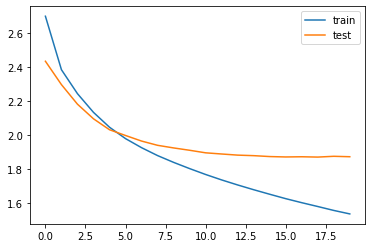

In [86]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [87]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [88]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

In [89]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [90]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [91]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [92]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [93]:
for i in range(500, 1000):
    print("원문 : ",seq2text(encoder_input_test[i]))
    print("실제 요약문 :",seq2summary(decoder_input_test[i]))
    print("예측 요약문 :",decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 :  used control small tomatoes potatos follow directions frequently control safe way treat certain insects would definitely buy product 
실제 요약문 : works if you the directions 
예측 요약문 :  great flavor


원문 :  love cacao bliss sweet treat right jar spoonful would want eat much one however quite rich order 
실제 요약문 : bliss is an description 
예측 요약문 :  love these


원문 :  really good popcorn like movies buy enough butter salt tonight 
실제 요약문 : best ever had 
예측 요약문 :  great popcorn


원문 :  good tea loyal tea drinker like need least bags per cup good flavor satisfying drink like one reviewer pointed earlier taste finishing cup 
실제 요약문 : good tea 
예측 요약문 :  good tea


원문 :  love idea champagne truffles flavorless ended throwing away half box 
실제 요약문 : great concept bad taste 
예측 요약문 :  terrible


원문 :  tastes great wife drink tea occasion regular grocery stores dont usually stock 
실제 요약문 : taste 
예측 요약문 :  great tea


원문 :  vegetarian years new rodeo purchased product high hopes basis amazon 

예측 요약문 :  great tea


원문 :  many kinds favorite still heinz 
실제 요약문 : close but not quite 
예측 요약문 :  love this tea


원문 :  received shipment yesterday one bottles broken transport leaving shipping box ruined taste spectacular label lists ingredient natural coconut water sure previous poster seen potassium added water indication label might buy one two time store necessarily much 
실제 요약문 : vita coco just 
예측 요약문 :  bad customer service


원문 :  must gotten scraps tree inches tall crossed since adding water loose nothing like pictures descriptions green box ashamed send anything like would never bought would never accepted gift probably trash next week money tree lost money make killing customers internet 
실제 요약문 : it will be away looks like 
예측 요약문 :  not as advertised


원문 :  everybody sent past years loved chocolate say rich gourmet superior sees ghirardelli godiva etc 
실제 요약문 : have not tried these yet 
예측 요약문 :  the best


원문 :  cannot go wrong remember better coffee money cannot buy

예측 요약문 :  great coffee


원문 :  live alaska everything saved alot money received time ordering 
실제 요약문 : com 
예측 요약문 :  great price


원문 :  part dr oz tea diet works like charm lost inches already days 
실제 요약문 : part of dr oz tea diet 
예측 요약문 :  good stuff


원문 :  really liked oatmeal great maple syrup flavor cooks quickly reviewers seem think tastes different previous batches used eat see difference good breakfast food 
실제 요약문 : great instant oatmeal 
예측 요약문 :  great taste


원문 :  like name says crunchy nut cereal lightly sweet stays crunchy milk nutty flavor first really care taste couple bowls past week flavor grown strong almost peanut butter flavor cereal great cereal different tasty sure would buy 
실제 요약문 : it crunchy 
예측 요약문 :  great taste


원문 :  ordered price arrived box said fits many keurig brewers bit worried pod fit perfectly coffee made outstanding understand concern airtight storing airtight container works like little less plastic put trash ekobrew cup favorite things ke

예측 요약문 :  good but not great


원문 :  drinking brand chai latte awhile till walmart quit carrying prefer bags new updated version tins much foam compared bag version completely love product 
실제 요약문 : prefer the packages to the 
예측 요약문 :  great chai


원문 :  package suggests adding nuts raisins grated carrots coconut added pecans raisins next time try suggestions bread good sweet spicy enough ordered 
실제 요약문 : delicious pumpkin bread 
예측 요약문 :  tasty but little too salty


원문 :  almond flour beats guys freshness price used flours baking get moist heavy texture used alone baking vegetable muffins small vegetable loaves great treat great alternative celiac disease 
실제 요약문 : now almond flour 
예측 요약문 :  great product


원문 :  wife says flavored coffee become one favorites also really likes gloria jean cappuccino good taste smooth flavor help wake morning 
실제 요약문 : cup butter toffee coffee by gloria 
예측 요약문 :  good coffee


원문 :  cats really enjoy food economical way purchase store usually stoc

예측 요약문 :  not what expected


원문 :  love bars first started eating starbucks buy box delicious nutritious amazon good price nicely wrapped packaged fresh 
실제 요약문 : love these 
예측 요약문 :  love these


원문 :  love french vanilla coffee gives day great start easy use one cup time waste 
실제 요약문 : delicious 
예측 요약문 :  great coffee


원문 :  great fast cook pasta packaging packaging quite weird came shipping box large plastic bag without description hope got bought 
실제 요약문 : great pasta 
예측 요약문 :  great product


원문 :  got keurig love hot chocolate said good quick cup brew cup size add bit milk half half otherwise bit watery still get fix best hot chocolate keurig tried yet 
실제 요약문 : pretty good 
예측 요약문 :  good stuff


원문 :  justin individual nut butter packs delicious perfect back packing trips bring every time without highly recommended product 
실제 요약문 : fantastic 
예측 요약문 :  delicious


원문 :  year old mom watch sugar send candies often favorite flavors sugar free delivered door like receive su

예측 요약문 :  my dog loves these


원문 :  product okay words edible reasonably priced however greasy care greasy foods first time ever purchased greasy jerky think grandchildren liked better ate however purchasing personal consumption future 
실제 요약문 : disappointed 
예측 요약문 :  not bad


원문 :  fan coconut water say product good fresh coconut water get india good among options us feel expensive still love 
실제 요약문 : simply love it 
예측 요약문 :  coconut water


원문 :  love chocolate kcups getting company cheaper amazon www amazon com gp product ref cm cr rev prod 
실제 요약문 : coffee 
예측 요약문 :  great


원문 :  actually know mild hot spicy great put delicious 
실제 요약문 : hot 
예측 요약문 :  great


원문 :  early age beagle picky eating little freeze dried chicken liver food gave eat become part routine 
실제 요약문 : picky eater 
예측 요약문 :  my son loves this


원문 :  far best bread mix tried quite found pre baked breads better far find mix actually better many frozen breads try adding herbs spices mix flavor like great bas

예측 요약문 :  my dog loves these


원문 :  tried black cherry version liked one much better great orange taste plus benefit juice corn syrup sweetner worried use carbonation helps make satisfying drink quench thirst knowledge healthy satisfies mind well 
실제 요약문 : super satisfying taste 
예측 요약문 :  great tasting


원문 :  agree tastes like trader joe version cannot believe discontinued best sauce keep finding new way use eating less less meat know tastes great veggie burgers eggs fish worth experimenting 
실제 요약문 : joe out 
예측 요약문 :  the best


원문 :  good quality ghee tried another brand odd aftertaste one one good enough eat spoon wanted mm 
실제 요약문 : great ghee 
예측 요약문 :  good but not great


원문 :  okay black lab eat almost anything green peas banana peels fruit trash feel important tell significantly review said seem really like food pleased definitely consider future clue finicky dog would bag good size trial run though shelter could use unused portion decided standards daisy liked 
실제 요약문 : m

예측 요약문 :  my dog loves them


원문 :  tried various zevia sodas buying multi flavor case liked several flavors much dr zevia big dr pepper fan dr zevia even close worst flavors tried tasted almost like watered cherry cough syrup wicked aftertaste buy 
실제 요약문 : terrible aftertaste 
예측 요약문 :  not so good


원문 :  feeling people either going love hate hated salt pepper combo extremely aggressive chunks salt large sometimes make crunch bite particularly large one pepper also large flakes lot felt bit sick stomach even thought makes little loved emerald product line one give respect taking chances think went aggressive one 
실제 요약문 : bold but not for me 
예측 요약문 :  good stuff


원문 :  mixed nuts arrived two days packaged arrived items ordered box easy open unlike almost need saw reach contents ordered food line pleased found fresh nuts fresh salted perfectly taste greasy happy try products 
실제 요약문 : service from amazon for an excellent product 
예측 요약문 :  great deal


원문 :  bought three pack taste

예측 요약문 :  great coffee


원문 :  chose sea salt flavor big seasoned chips husband decided wanted rosemary could shake bag pleased lightly salted extremely crunchy satisfy without us worry soybean inferior oils pleased 
실제 요약문 : tasty crunchy 
예측 요약문 :  great nuts


원문 :  like dried onion around give certain dishes extra punch great nice organic come plastic sealed bag moved glass jars 
실제 요약문 : great as far as dried onion goes 
예측 요약문 :  great product


원문 :  purchased grocery store found tasty easy lunch take work wanted case daughter take order arrived received one bowl case called amazon said would send replacement right away next shipment contained one bowl amazon refunded money said would look told wait least week reorder till problem solved flavor ordered shipped correctly 
실제 요약문 : problem with ordering 
예측 요약문 :  good product poor packaging


원문 :  finicky loves food one wet foods actually eat loved three cats well definitely buying 
실제 요약문 : pet food 
예측 요약문 :  my dog loves this

예측 요약문 :  not as good as the original


원문 :  brand lives name also brews well bitter taste leaves one feeling satisfied one cup 
실제 요약문 : rich but very satisfying 
예측 요약문 :  great coffee


원문 :  fresh product cats normally love product old smell 
실제 요약문 : on the shelf too long 
예측 요약문 :  great product


원문 :  cookies come different sizes want small treat look smaller size big lb gsd right found flavor helped settle upset tummy since changed grain free food stomach issues anymore however help days would see eating grass like hungry cow 
실제 요약문 : big cookies for our big 
예측 요약문 :  good but not for small


원문 :  keto consuming less carbs per day terrific addition diet terrific way cut half calories fat meal supplement meal noodles tried three varieties difference form easy make add sauce stir fry liquid smell gross washes nicely equivalent pasta pretty damn close considering nothing also made pizza crust using noodles mm 
실제 요약문 : love these noodles 
예측 요약문 :  good alternative to make




예측 요약문 :  very good


원문 :  best cocoa way better anything find supermarket even better highly rated cocoas tried amazon also dissolves water really easily makes amazing hot chocolate 
실제 요약문 : the best found 
예측 요약문 :  the best


원문 :  know hard find soup sugar really really hard eat sugar discovering amy soups gift despite healthy ingredients delicious make dinner lunch busy day much easier order subscribe save come affordable amount per bad entire lunch 
실제 요약문 : soup without sugar 
예측 요약문 :  great for the price


원문 :  sorry say thinking maybe came name sounded yummy attractive could taste peach champagne simply given spread easily color pretty toast others table felt way sure eating quite sweet particularly encourage looking fruity flavor maybe raspberry maybe peach disappointment 
실제 요약문 : cannot taste anything 
예측 요약문 :  not as good as thought


원문 :  buying tea another store already knew good fact think best tea one get kind hooked even awake first cup morning anyway convenient

예측 요약문 :  not so good


원문 :  drinking red rooibos green tea nearly year daily choice tea tea bitterness caffeine like green teas smooth drink many cups day without aftertaste negative caffeine effect also heard rooibos green tea much higher antioxidants green tea highly recommend product 
실제 요약문 : the best green tea have ever had 
예측 요약문 :  green tea


원문 :  price pay size cup getting taken purchase buy traditional mix company get better value better taste richer texture horrible mix tastes ok nothing decent cup chocolate flavored water thickness swiss miss grocery store hot chocolate beats hands getting convenience using cups much one begin avoid 
실제 요약문 : small cup of chocolate flavored water 
예측 요약문 :  not so good


원문 :  good rice got sale liked better idea meant taste holds real thing last package experimenting adding lemon sauce chunk light tuna divine 
실제 요약문 : liked this lot 
예측 요약문 :  not good


원문 :  buying vet expensive glad found online dog loves thanks 
실제 요약문 : my dog lo

예측 요약문 :  not as good as the picture


원문 :  absolutely loves greenies chews good glad likes well pleasant smell even cats love greenies feline variety recommend highly 
실제 요약문 : wonderful chewy healthy treat 
예측 요약문 :  my dog loves these


원문 :  tasty clearly must love peanuts enjoy bar caramel inside chewy sweet use combination meal replacement snack boost daily protein needs need extra protein bars part overall plan 
실제 요약문 : quick yummy way to get your protein 
예측 요약문 :  delicious


원문 :  husband cannot live without hour much economical order case 
실제 요약문 : hour juice 
예측 요약문 :  great product


원문 :  pocket coffees something discovered air force unit southern italy positively incredible dark chocolate filled espresso big pick used night helping stay awake taste fantastic unusual trying get years recently treated amazon half paid gift give pocket coffees try unusual exciting children taste coffee pretty intense 
실제 요약문 : chocolates 
예측 요약문 :  best coffee ever


원문 :  like many atkin